In [301]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
mpl.style.use('bmh')

In [302]:
import numpy as np

In [303]:
from lint_analysis.bin_counts import cache

In [5]:
tokens = cache.token_counts(10000)

In [6]:
import re

from collections import OrderedDict

tokens = OrderedDict([
    (t, c) for t, c in tokens.items()
    if not re.match('^[0-9ivx.]+$', t)
])

In [7]:
data = []

for i, (token, count) in enumerate(tokens.items()):
    
    series = cache.token_series(token)
    exp_var = series.sum() * (1/100) * (1 - 1/100)
    
    data.append((count, series.var(), exp_var))
    
    if i % 1000 == 0: print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [9]:
import pandas as pd

df = pd.DataFrame(
    data,
    columns=('count', 'var', 'exp'),
    index=tokens.keys(),
)

In [10]:
import math

df['score'] = df.index.map(
    lambda t: df.loc[t]['var'] / df.loc[t]['exp']
)

In [11]:
top = df.sort_values('score', ascending=False).head(500)

In [12]:
import random

shuffled = list(top.index)
random.shuffle(shuffled)

In [13]:
series = {
    token: cache.token_series(token)
    for token in top.index
}

In [14]:
from itertools import combinations
from scipy.spatial import distance

In [15]:
d = []
for i, (t1, t2) in enumerate(combinations(shuffled, 2)):
    
    s1 = series[t1]
    s2 = series[t2]
    
    d.append(distance.euclidean(s1/s1.sum(), s2/s2.sum()))

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram

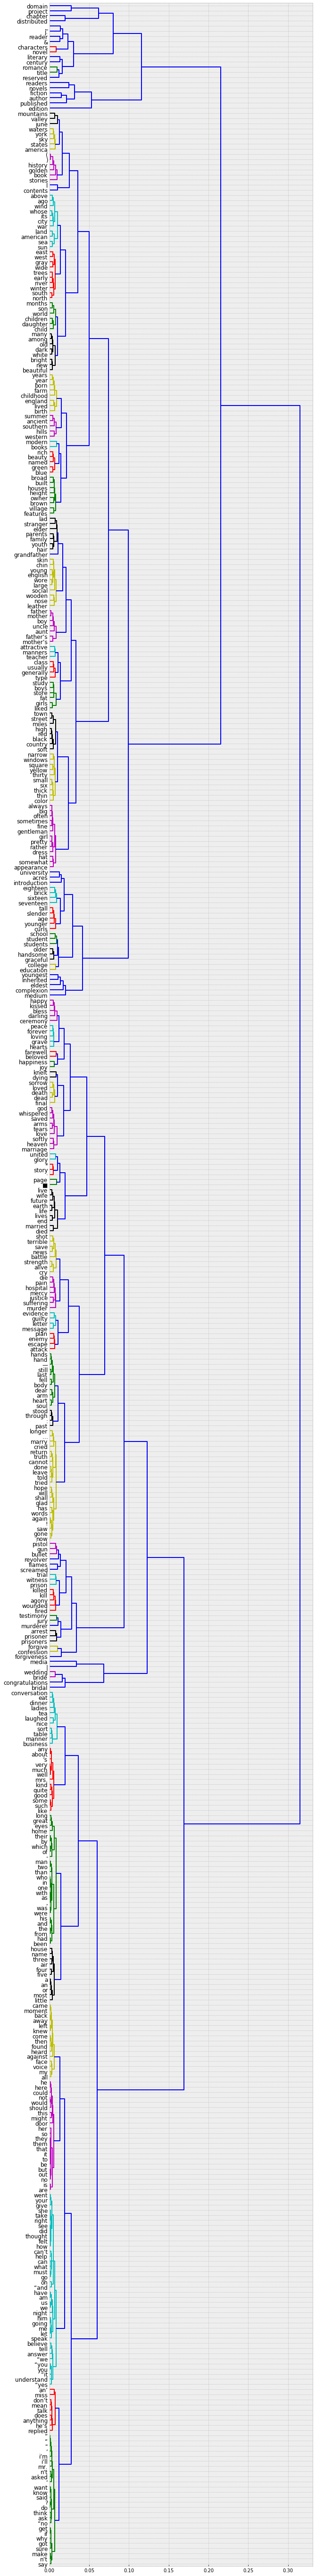

In [17]:
link = linkage(d, method='ward')

plt.figure(figsize=(10, 100))

dendrogram(
    link,
    labels=shuffled,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=12,
    color_threshold=0.01,
)

plt.show()

In [18]:
from scipy.cluster.hierarchy import fcluster

In [19]:
groups = fcluster(link, 0.01, 'distance')

for gid in range(min(groups), max(groups)+1):
    print('\n', gid)
    for i, j in enumerate(groups):
        if j == gid:
            print(shuffled[i])


 1
n’t
said
’
why
“
if
say
got
‘
ask
i’ll
know
i’m
mr.
sure
"
”
“no
asked
do
want
get
?
n't
make
think

 2
anything
miss
an’
mean
replied
does
talk
don’t
he’s

 3
let
understand
take
what
you
answer
help
your
tell
can
go
felt
can’t
did
am
“and
oh
“yes
going
“you
thought
right
she
we
him
must
went
have
see
night
me
“we
speak
give
“it
believe
how
us

 4
out
to
so
should
be
it
that
could
here
door
would
might
her
not
he
are
no
but
is
them
they
this

 5
all
moment
knew
away
left
voice
against
came
heard
found
face
back
then
come
my

 6
air
five
most
an
three
four
name
little
or
house
a

 7
of
home
and
one
eyes
-
been
which
as
his
from
in
by
two
great
long
were
their
with
man
the
had
who
was
,
than

 8
good
well
about
quite
any
much
very
mrs.
like
’s
such
kind
some

 9
table
nice
eat
business
sort
laughed
conversation
ladies
manner
tea
dinner

 10
bride
wedding

 11
congratulations

 12
bridal

 13
|

 14
media

 15
confession
forgive

 16
forgiveness

 17
prisoners
prisoner
arrest

 18
ju

In [298]:
import math

from scipy.ndimage.measurements import center_of_mass
from itertools import cycle
    
class Cohorts(dict):
        
    def add(self, key, label, tokens):
        
        if type(tokens) is str:
            tokens = list(map(str.strip, token_str.strip().splitlines()))

        self[key] = (label, tokens)
        
    def density(self, key):
        _, tokens = self[key]
        counts = np.array([cache.token_series(token) for token in tokens]).sum(0)
        return counts / counts.sum()
        
    def center_of_mass(self, key):
        density = self.density(key)
        return center_of_mass(np.array(density))[0]
    
    def order_center_of_mass(self):
        return sorted(self.keys(), key=lambda k: self.center_of_mass(k))
    
    def plot_multiples(self, cols=4):

        # Get row count and figure size.
        rows = math.ceil(len(self) / cols)
        
        plt.figure(figsize=(cols*2.5, rows*2.5))
        
        keys = reversed(list(self.keys()))
        
        for i, key in enumerate(keys):
            
            label, tokens = self[key]
            
            ax = plt.subplot2grid((rows, cols), (math.floor(i/cols), i%cols))
            ax.set_ylim((0.005, 0.04))
            
            for token in tokens:

                # Configure axes.
                ax.set_title(label, fontsize=8)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
                ax.tick_params(labelsize=8)

                # Plot the series.
                series = cache.token_series(token.strip())
                ax.plot(series/series.sum(), c='#1d6ae5', lw=0.5)
                
        plt.tight_layout(h_pad=1)
        plt.show()
        
    def plot_cohorts(self, cohorts, w=8, h=8):
            
        plt.figure(figsize=(w, h))
        plt.ylim((0.005, 0.04))
        
        colors = cycle(range(10))
        
        lines = []
        for key in cohorts:
            
            _, tokens = self[key]
            color = 'C%d' % next(colors)
            
            for token in tokens:
                series = cache.token_series(token)
                line, = plt.plot(series/series.sum(), label=token, color=color, lw=1)
                lines.append(line)

        plt.legend(
            handles=lines,
            bbox_to_anchor=(1.03, 1),
            loc=2,
            borderaxespad=0,
        )

        plt.xlabel('Narrative time')
        plt.ylabel('Relative frequency')

In [299]:
from textwrap import wrap
from boltons.iterutils import chunked

groups = fcluster(link, 0.01, 'distance')

cohorts = Cohorts()

for gid in range(min(groups), max(groups)+1):
    
    tokens = []
    for i, j in enumerate(groups):
        if j == gid:
            tokens.append(shuffled[i])

    if len(tokens) > 1:
        
        dtokens = tokens[:10]
        
        dtokens[0] = '%d: %s' % (gid, dtokens[0])
        
        if len(tokens) > 10:
            dtokens.append('(%d more)' % (len(tokens) - 10))
            
        lines = wrap(', '.join(dtokens), 30)
        title = '\n'.join(lines)
        cohorts.add(gid, title, tokens)

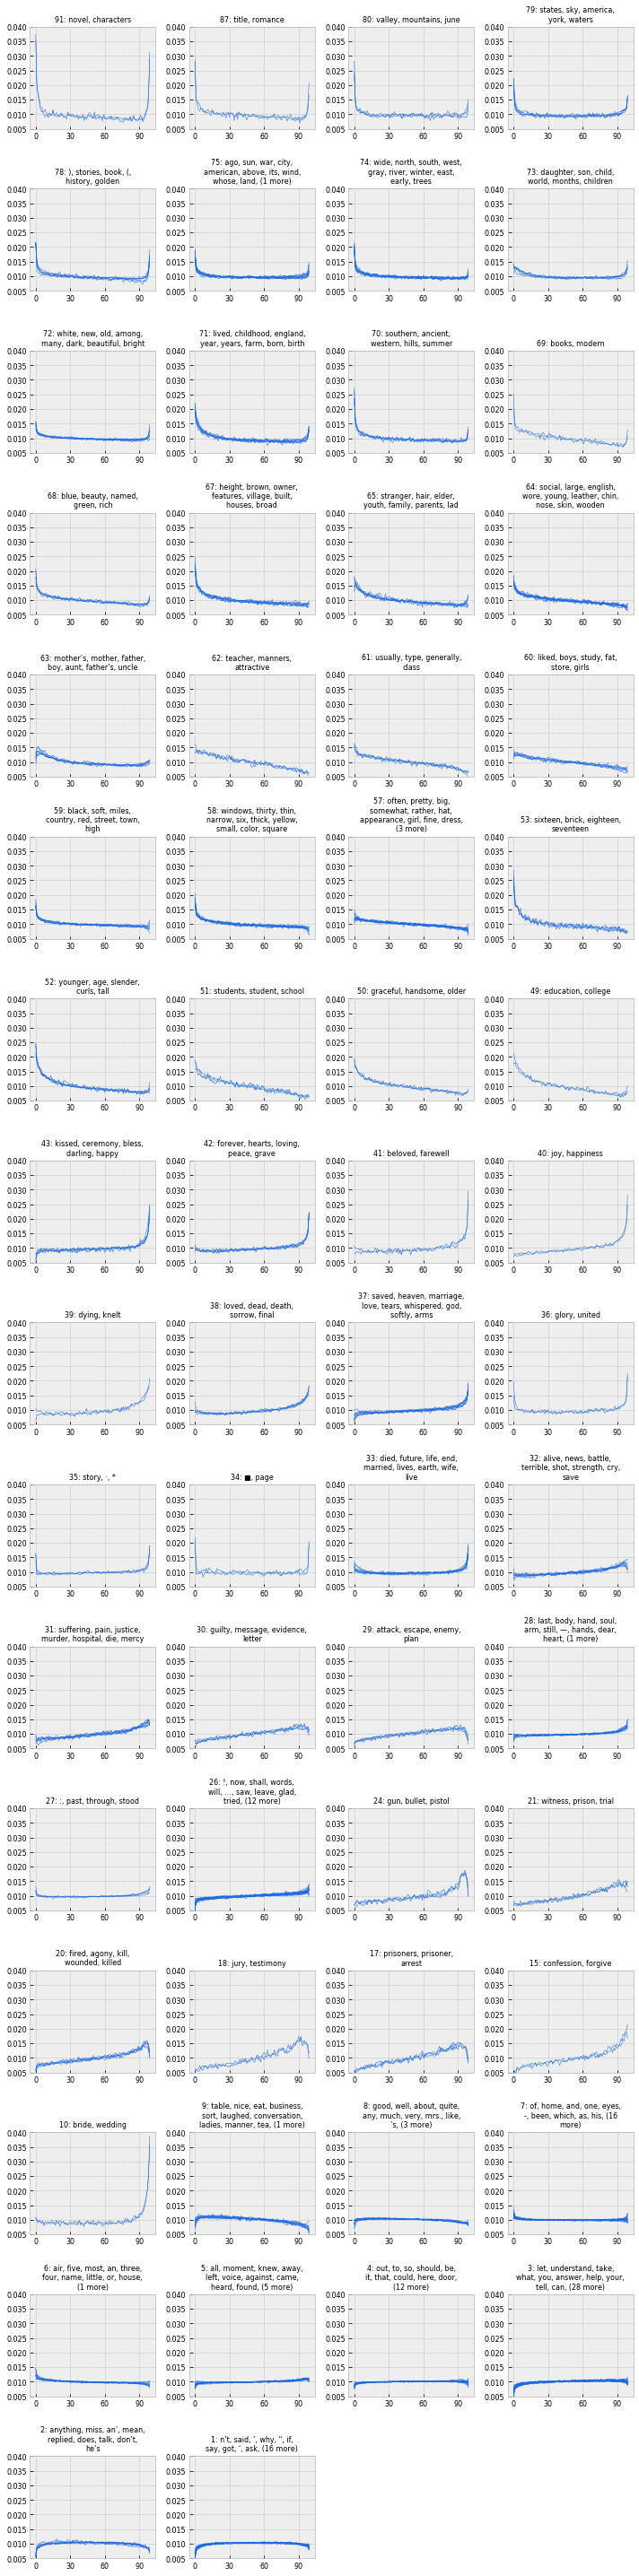

In [300]:
cohorts.plot_multiples()

# Dwellings

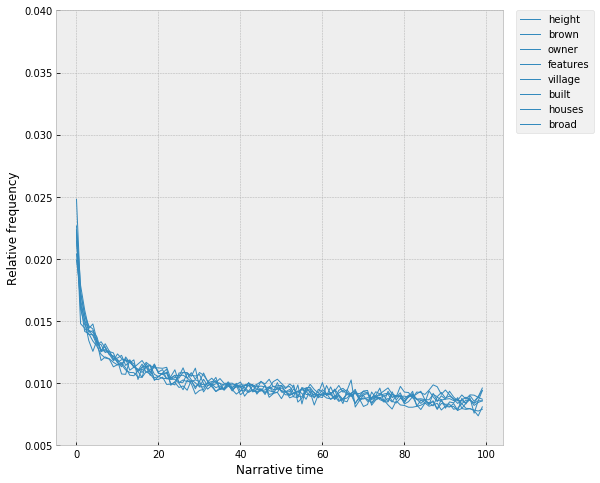

In [279]:
cohorts.plot_cohorts([67])

# Descriptions of people

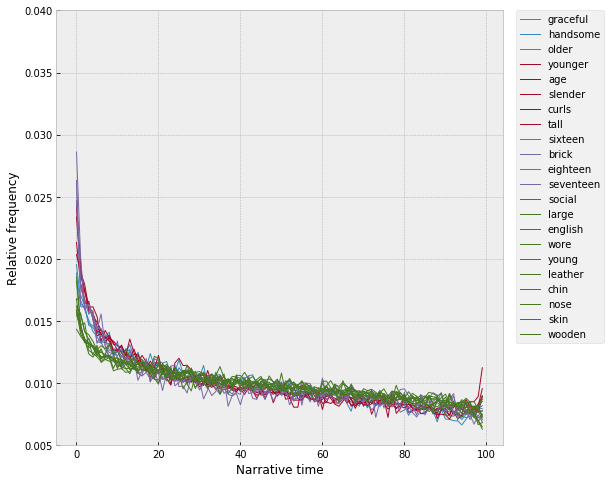

In [280]:
cohorts.plot_cohorts([50, 52, 53, 64])

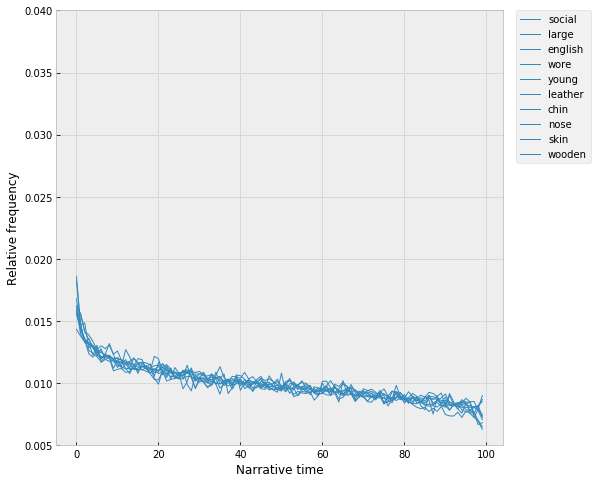

In [281]:
cohorts.plot_cohorts([64])

# Color, beauty

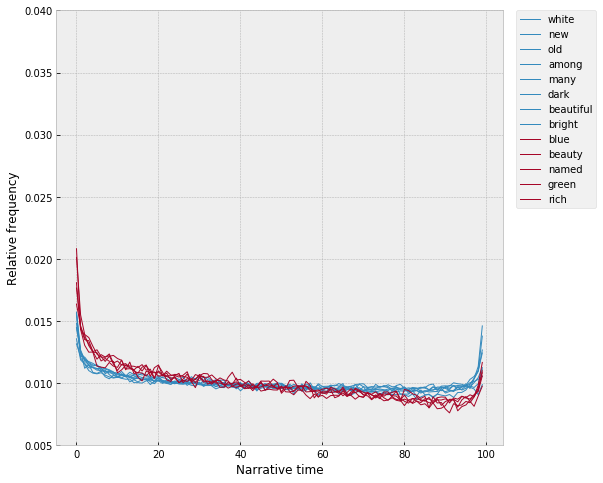

In [282]:
cohorts.plot_cohorts([72, 68])

# Education

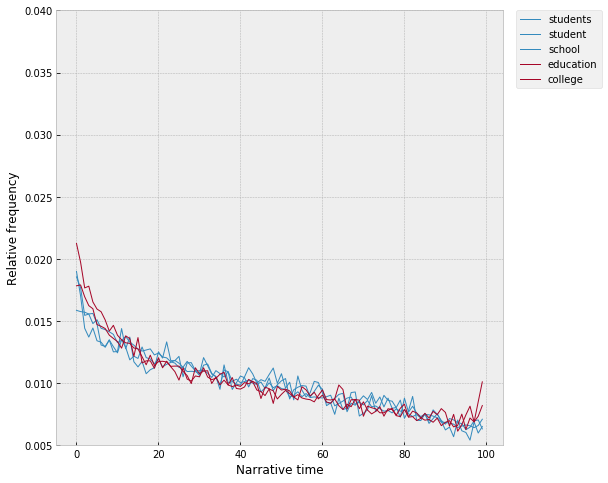

In [283]:
cohorts.plot_cohorts([51, 49])

# Generalization, categorization

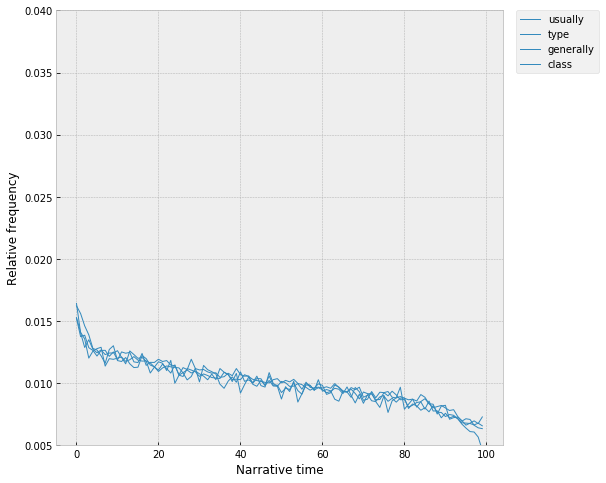

In [284]:
cohorts.plot_cohorts([61])

# How often? To what extent? And, fashion.

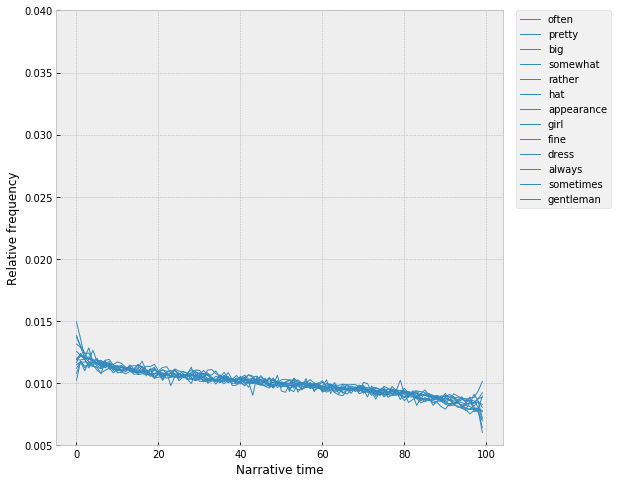

In [285]:
cohorts.plot_cohorts([57])

# Geographic location, the outdoors, America

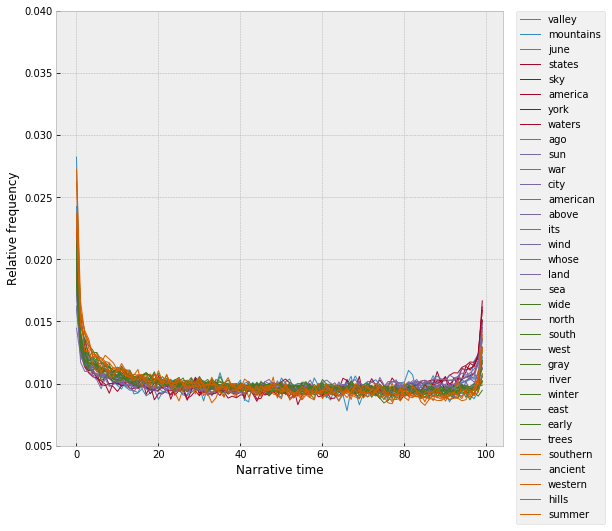

In [286]:
cohorts.plot_cohorts([80, 79, 75, 74, 70])

# Family

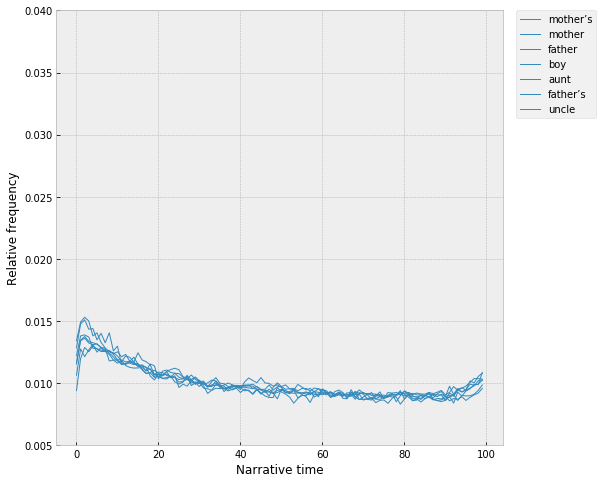

In [287]:
cohorts.plot_cohorts([63])

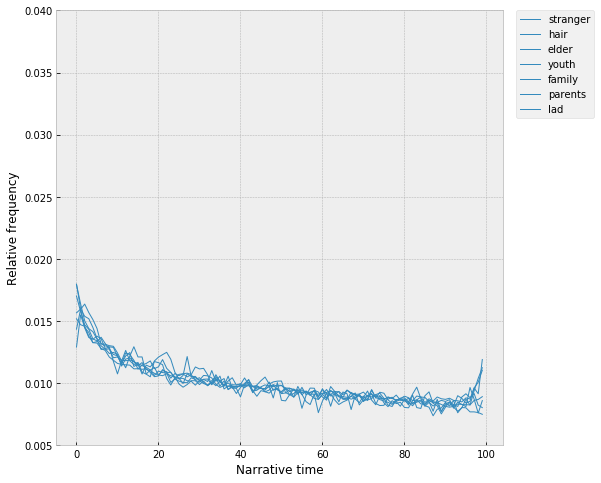

In [288]:
cohorts.plot_cohorts([65])

# Childhood

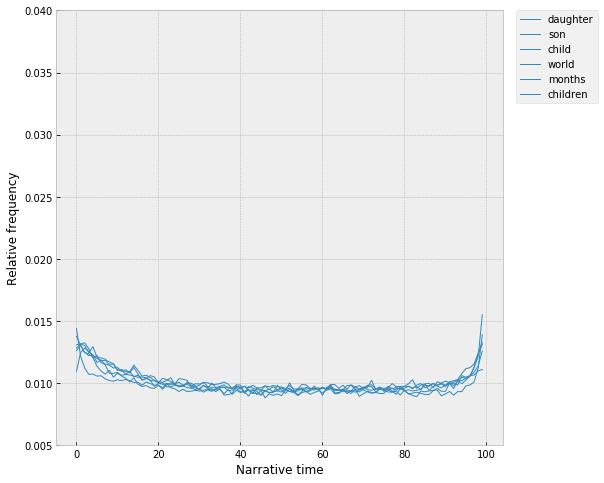

In [289]:
cohorts.plot_cohorts([73])

# (Ladies) eating and laughing

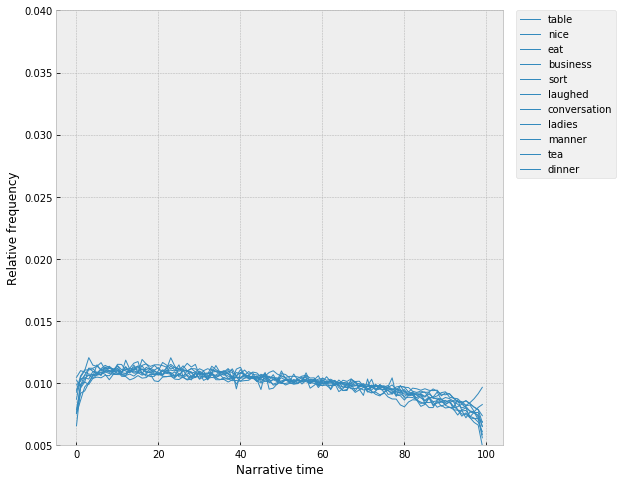

In [290]:
cohorts.plot_cohorts([9])

# Goodness, intensification

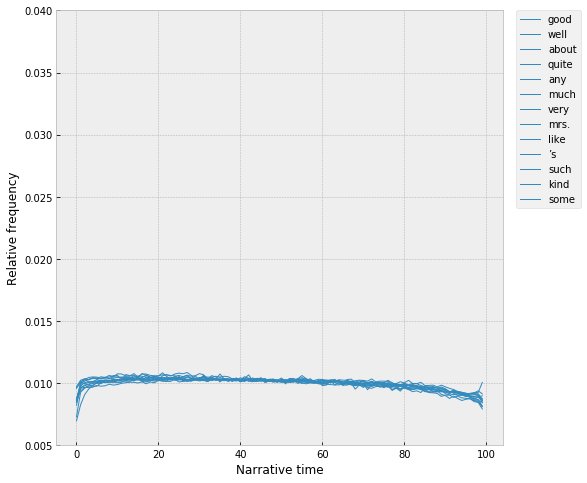

In [291]:
cohorts.plot_cohorts([8])

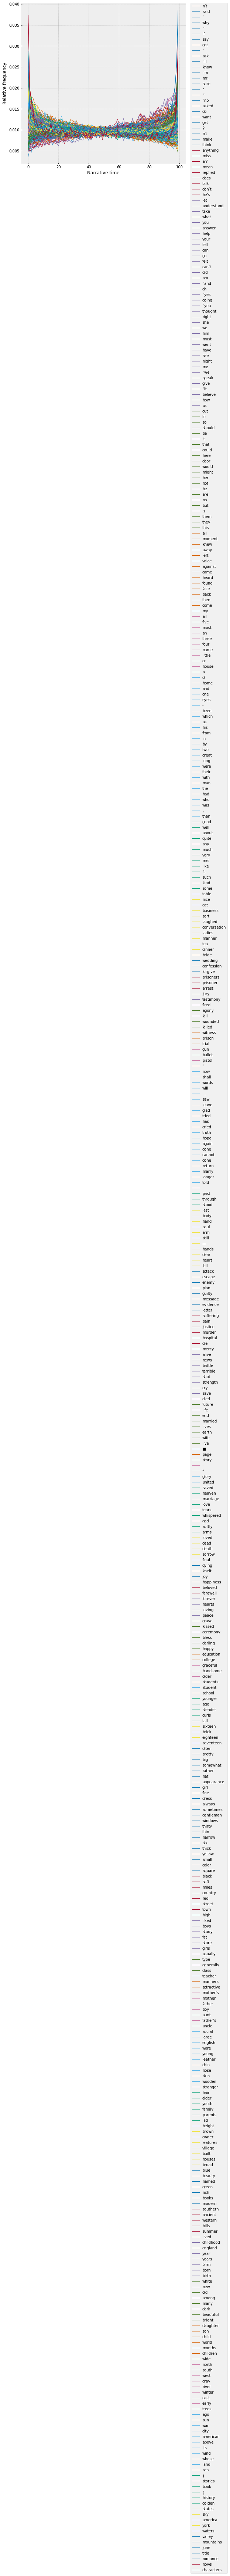

In [273]:
cohorts.plot_cohorts(cohorts.keys())

- education some of the most exclusively beginning-heavy words. though interesting that "college" also ticks up somewhat at the end, which I guess makes sense, in the sense that college can be the beginning of adulthood, or the end of adolescence.

- but, generally, beginning is dominated by words that have to do with the *description* - body parts (chin, nose, hair), personality traits and characteristics (handsome, graceful), body size (tall, slender, fat), physical dimensions (thick, narrow), materials (wooden), age (sixteen, seventeen) - the fictive world getting boostrapped into existence, the "surface" rendered into place.

- some things are less concrete and more conceptual - eg, the cluster that might be glossed as "categorization" or "generalization" - usually, generally, type, class - high at the very beginning and falling off gradually across the narrative. beyond just physical appearance, I suppose, this is the narrative setting the routines and hierarchies of the fictional world - what tends to happen, what's normal, how things (mostly people, I assume?) sort out into "types" and "classes"? I'm not sure I trust "class" entirely, since it's so polysemic - could also be "class" in the sense of school, would need to spot-check passages to be sure.

- along the same lines, cohort that might be described as "how often, and to what extent?" - rather, somewhat, often. essentially - *qualification*, perhaps often in the context of describing the appearance or habits of female characters (girl, dress, pretty)?

- also big cohort of words that are high at beginning and also spike at the end to a lesser extent, all related to physical location (cardinal directions, toponyms), the outdoors, physical environment. the beginning makes sense - this is the narrative rendering the fictive world into existence, painting in the scene, describing the location; what the physical construction of a stage is for a play, this is for narrative fiction. the end is less clear to me, though - why physical description at the end, when the world has presumably already been bootstrapped into existence, and certainly at that point it seems unlikely that the narrative would be crossing into new fictive territory at the very end that needs to be described for the first time? maybe - to pick up with the analogies, if we think of the narrative as a kind of "camera" onto the world - this is the camera panning out at the end, pulling back into a wide shot of the landscape of the story, the characters gazing out over the mountains, the plains, the sea? a kind of reciprocal "wide shot" to match the description of the beginning?

- family also looks similar, though it splits into two parts - words describing family relationships (mother, father, aunt, uncle) are relatively low in the first percentile, then spike dramatically in the next few percentiles, before falling off across the text and then rising again at the end. I suppose - the raw physical world first has to get sketched into place, and then the narrative turns to characters, and the first order of business is to lay out the family tree? meanwhile, though, words specifically about (the birth of) children - daughter, son, child, children, childhood, born, birth - are high at the very beginning, fall off in the middle, and then spike even higher at the end than at the beginning. again, childhood at the beginning is intuitive - narratives map onto lives, begin with birth and childhood - and I suppose that children at the end is, essentially, the byproduct of the marriage plot? "childhood" in the first percentile is the childhood of the protagonist, "childhood" in the 99th is the childhood of her children?

- after the words that spike at the very beginning - two sort of funny cohorts that rise quickly to a peak around 15-20%, and then fall off gradually through the center, before cratering at the end. first, with the more dramatic peak, and a sharper falloff - nice ladies eating food, the meal, which seems to often be the very first "set piece" of the narrative after the descriptive beginning? the world is sketched into existence, the characters introduced - and then they (especially women?) sit down for a meal and pleasant conversation?

- very similar to this, also peaking right around 20% but with a slightly more shallow falloff across the middle, is this cohort, which seems both coherent and mysterious, and almost impossible to gloss - goodness, more-ness? 